# Contextual Embeddings from Clinical Notes Improves Prediction of Sepsis

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import torch
import numpy as np
import re
import tqdm
import h5py
import matplotlib.pyplot as plt
from keras import Model
from keras.models import load_model, Sequential
from keras.layers import Dense, LSTM, Softmax, Input
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from torch import tensor
from transformers import AutoTokenizer, AutoModel
from torch.autograd import Variable 

## <span style = "color:blue">Preprocessing Data</span>

In [3]:
def preprocess(x):
    y = re.sub('\\[(.*?)\\]', '', x)  # remove de-identified brackets
    y = re.sub('[0-9]+\.', '', y)  # remove 1.2. since the segmenter segments based on this
    y = re.sub('dr\.', 'doctor', y)
    y = re.sub('m\.d\.', 'md', y)
    y = re.sub('admission date:', '', y)
    y = re.sub('discharge date:', '', y)
    y = re.sub('--|__|==', '', y)
    return y

In [4]:
def preprocessing(df_less_n):
    df_less_n['TEXT'] = df_less_n['TEXT'].fillna(' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\n', ' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\r', ' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].apply(str.strip)
    df_less_n['TEXT'] = df_less_n['TEXT'].str.lower()

    df_less_n['TEXT'] = df_less_n['TEXT'].apply(lambda x: preprocess(x))
    
    chunk_size = 140

    # to get 512 words chunks for sepsis tasks
    df_len = len(df_less_n)
    want = pd.DataFrame({'ID': [], 'TEXT': [], 'Label': []})
    for i in range(df_len):
        x = df_less_n.TEXT.iloc[i].split()
        n = int(len(x) / chunk_size)
        for j in range(n):
            want = want.append({'TEXT': ' '.join(x[j * chunk_size:(j + 1) * chunk_size]), 'Label': df_less_n.SEPSIS.iloc[i],
                                'ID': df_less_n.SUBJECT_ID.iloc[i]}, ignore_index=True)
        if len(x) % chunk_size > 10:
            want = want.append({'TEXT': ' '.join(x[-(len(x) % chunk_size):]), 'Label': df_less_n.SEPSIS.iloc[i],
                                'ID': df_less_n.HADM_IDleft.iloc[i]}, ignore_index=True)

    return want

In [5]:
clinical_notes = pd.read_csv('NOTEEVENTS.csv')
diagnoses_icd = pd.read_csv('DIAGNOSES_ICD.csv')
diagnoses_icd['SEPSIS'] = diagnoses_icd['ICD9_CODE'].apply(lambda x: True if x == '99591' else False) 

In [6]:
clinical_notes_mod = clinical_notes.join(diagnoses_icd, lsuffix = 'left', rsuffix = 'right', on = 'SUBJECT_ID', how = 'inner')

In [7]:
new_clinical_notes = clinical_notes_mod[['SUBJECT_ID', 'HADM_IDleft', 'ROW_IDleft', 'ROW_IDright', 'CATEGORY', 'DESCRIPTION', 'TEXT',
                                        'SEPSIS', 'ICD9_CODE']]
text = new_clinical_notes.TEXT

In [8]:
sepsis_df = new_clinical_notes[new_clinical_notes.ICD9_CODE == '99591']
not_sepsis_df = new_clinical_notes[new_clinical_notes.ICD9_CODE != '99591']

In [9]:
sepsis_sample = sepsis_df.sample(n = 250, random_state = 57)
not_sepsis_sample = not_sepsis_df.sample(n = 250, random_state = 82)

In [10]:
sample_df = pd.concat([sepsis_sample, not_sepsis_sample], axis = 0)

In [11]:
df_sample = new_clinical_notes.sample(n = 1000, random_state = 904)

## <span style = "color:blue">TF-IDF Implementation</span>

In [12]:
corpus = sample_df.TEXT.to_list()
X = corpus
labels = sample_df.SEPSIS.tolist()
y = labels

In [13]:
vectorizer = TfidfVectorizer().fit(X)

tfidf_vector_X = vectorizer.transform(X).toarray()

In [14]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_vector_X, labels,
                                                                           test_size = 0.2, train_size = 0.8,
                                                                           shuffle = True)

In [15]:
X_train_tfidf = np.reshape(X_train_tfidf, (X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1]))
X_test_tfidf = np.reshape(X_test_tfidf, (X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1]))

In [16]:
# X_train_tfidf = X_train_tfidf.tolist()

In [17]:
y_train_tfidf, y_test_tfidf = np.array(y_train_tfidf), np.array(y_test_tfidf)

In [18]:
model = Sequential()
model.add(LSTM(6573, input_shape = (None, 6573)))
model.add(Softmax())

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6573)              345660924 
                                                                 
 softmax (Softmax)           (None, 6573)              0         
                                                                 
Total params: 345,660,924
Trainable params: 345,660,924
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])
model.fit(X_train_tfidf, y_train_tfidf, epochs = 25, batch_size = 10, verbose = 0)

In [21]:
model.save('tfiddf_sepsis_model.h5')

In [22]:
tfidf_preds = model.predict(X_test_tfidf)

In [23]:
tfidf_preds.shape

(40, 6573)

In [24]:
tfidf_softmax = Softmax()

In [25]:
predicted_labels = np.round(tf.math.reduce_sum(tfidf_softmax(tfidf_preds), axis = 1))

In [26]:
predicted_labels = predicted_labels.astype(dtype = 'int')

In [27]:
y_test_tfidf = y_test_tfidf.astype(dtype = 'int')

In [65]:
tfidf_accuracy = (predicted_labels == y_test_tfidf).sum() / len(predicted_labels)

In [29]:
tfidf_roc_auc = roc_auc_score(y_test_tfidf, predicted_labels)

## <span style = "color:blue">ClinicalBERT + LSTM Implementation</span>

In [30]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
conf = model.config

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
def BERT(inp):
    '''
    PARAMETERS:
    
    inp - Number of rows from DataFrame
    
    RETURNS:
    
    features - Feature sets corresponding to each note
    '''
    tensor_list = []
    idx_list = []
    for j in range(inp):
        output = []
#         print(f'The value of j is: {j}')
        text_df = preprocessing(df_sample[j:j + 1])
        if not text_df.TEXT.empty:
            # Pass each sentence to the ClinicalBERT model
            for i in range(len(text_df.TEXT)):
    #             print(f'*******ANALYZING TEXT*******')
#                 print(f'The length of TEXT is: {len(text_df.TEXT)}')
                encoding = tokenizer(text_df.TEXT[i], return_tensors = 'pt')
                bert_output = model(**encoding)
                last_hidden_state = bert_output['last_hidden_state']
    #             print(f'The value of last_hidden_state is: {last_hidden_state}')
#                 print(f'The dimensions of last_hidden_state is: {last_hidden_state.size()}')
                output.append(last_hidden_state)
    #             print(f'The value of output is: {output}')
#                 print(f'The length of output is: {len(output)}')
    #             print(f'The length of TEXT is: {len(text_df.TEXT)}')
            out_tensor = torch.cat(output, dim = 1)
#             out_tensor = torch.cat((torch.as_tensor(output), torch.as_tensor(df_sample.SEPSIS.iloc[j])), dim = 1)
    #         print(f'out_tensor: {out_tensor}')
#             print(f'The shape of out_tensor is: {out_tensor.size()}')
            out_tensor_mean = torch.mean(out_tensor, dim = 1)
    #         print(f'The value of out_tensor_mean is: {out_tensor_mean}')
#             print(f'The dimensions of out_tensor_mean is: {out_tensor_mean.size()}')
            tensor_list.append(out_tensor_mean)
#             print(f'The number of features in tensor_list is: {len(tensor_list)}')
            features = torch.stack(tensor_list, dim = 0)
            print(f'The shape of features is: {features.size()}')
        else:
            idx_list.append(j)
    return(features, idx_list)

In [32]:
features = BERT(sample_df.shape[0])

The shape of features is: torch.Size([1, 1, 768])
The shape of features is: torch.Size([2, 1, 768])
The shape of features is: torch.Size([3, 1, 768])
The shape of features is: torch.Size([4, 1, 768])
The shape of features is: torch.Size([5, 1, 768])
The shape of features is: torch.Size([6, 1, 768])
The shape of features is: torch.Size([7, 1, 768])
The shape of features is: torch.Size([8, 1, 768])
The shape of features is: torch.Size([9, 1, 768])
The shape of features is: torch.Size([10, 1, 768])
The shape of features is: torch.Size([11, 1, 768])
The shape of features is: torch.Size([12, 1, 768])
The shape of features is: torch.Size([13, 1, 768])
The shape of features is: torch.Size([14, 1, 768])
The shape of features is: torch.Size([15, 1, 768])
The shape of features is: torch.Size([16, 1, 768])
The shape of features is: torch.Size([17, 1, 768])
The shape of features is: torch.Size([18, 1, 768])
The shape of features is: torch.Size([19, 1, 768])
The shape of features is: torch.Size([20

In [33]:
sample_df = sample_df.drop(sample_df.index[features[1][0]])

In [34]:
labels = sample_df.SEPSIS.tolist()

In [35]:
labels = torch.as_tensor(labels)

In [42]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(features[0], labels, train_size = 0.8, 
                                                                        test_size = 0.2, shuffle = True)

In [43]:
X_train_lstm = tf.convert_to_tensor(X_train_lstm.detach().numpy())

In [44]:
# Convert PyTorch tensor to Tensorflow tensor
X_test_lstm = tf.convert_to_tensor(X_test_lstm.detach().numpy())
y_train_lstm = tf.convert_to_tensor(y_train_lstm.detach().numpy())
y_test_lstm = tf.convert_to_tensor(y_test_lstm.detach().numpy())

In [45]:
model = Sequential()
model.add(LSTM(768, input_shape = (None, 768)))
model.add(Softmax())

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 768)               4721664   
                                                                 
 softmax_2 (Softmax)         (None, 768)               0         
                                                                 
Total params: 4,721,664
Trainable params: 4,721,664
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(loss = 'mse', optimizer = 'adam')
model.fit(X_train_lstm, y_train_lstm, epochs = 25, batch_size = 10, shuffle = False, verbose = 0)

In [48]:
model.save('lstm_sepsis_model.h5')

In [49]:
lstm_preds = model.predict(X_test_lstm)

In [50]:
lstm_softmax = Softmax()

In [51]:
y_test_lstm = tf.cast(y_test_lstm, dtype = tf.int32)

In [52]:
lstm_preds = lstm_preds.sum(axis = 1).reshape(-1, 1)

In [56]:
lstm_preds = np.round(lstm_preds)

In [58]:
# lstm_preds = lstm_preds.astype(dtype = 'int')
# y_test_lstm = y_test_lstm.astype(dtype = 'int')
accuracy = accuracy_score(y_test_lstm, lstm_preds)
print(accuracy)
roc_auc_metric = roc_auc_score(y_test_lstm, lstm_preds)
print(roc_auc_metric)

0.425
0.5


## <span style = "color:blue">Results</span>

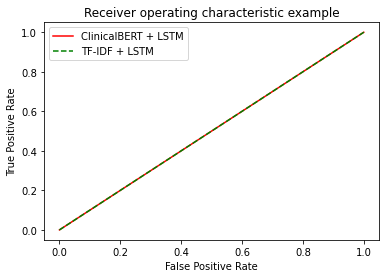

In [59]:
fpr1, tpr1, _ = roc_curve(y_test_lstm,  lstm_preds)
fpr2, tpr2, _ = roc_curve(y_test_tfidf, predicted_labels)

#create ROC curve
plt.plot(fpr1,tpr1, color = 'red')
plt.plot(fpr2, tpr2, linestyle = '--', color = 'green')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Receiver operating characteristic example")
plt.legend(['ClinicalBERT + LSTM', 'TF-IDF + LSTM'], loc = "best")
plt.show()

In [67]:
final_table = pd.DataFrame({
                            'Metric': ['Accuracy', 'ROC-AUC Score'],
                            'ClinicalBERT + LSTM': [accuracy, roc_auc_metric],
                            'TF-IDF + LSTM': [tfidf_accuracy, tfidf_roc_auc]})

In [68]:
final_table

,Metric,ClinicalBERT + LSTM,TF-IDF + LSTM
0,Accuracy,0.425,0.5
1,ROC-AUC Score,0.500,0.5
